# A Comparison of Classical Methods and VAE for Time Series Augmentation

In this tutorial, we compare a few traditional augmentation methods and a deep learning based method (variational autoencoder, VAE) (Kingma and Welling, 2019). We use the downstream performance metric to evaluate the augmentations. The downstream task is to detect heartbeat anomalies from ECG data.

In [2]:
#pip install tensorflow

In [4]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import kagglehub

In [6]:
#pip install tsgm

In [5]:
import tsgm

In [7]:
#pip install tslearn

In [6]:
from tslearn.neighbors import KNeighborsTimeSeriesClassifier

The dataset is extracted from the
MIT-BIH arrythmia database (Moody and Mark, 2001) on PhysioNet (Goldberger et al., 2000). Each sample consists of an ECG time series (187 timepoints)
and the associated class (no anomalies or anomalies). In the training set, we
have 2 000 randomly selected samples, 1 000 from each class. In the test set,
we also have 2 000 randomly selected samples, 1 000 from each class.

In [7]:
N = 1000
seq_len = 187

# Load data

path = kagglehub.dataset_download("shayanfazeli/heartbeat")
file = open(path + "/mitbih_test.csv", "r")
lines = file.readlines()
lines = sorted(lines[1:], key = lambda x: np.random.rand())
X0 = np.zeros((N, seq_len, 1))
X1 = np.zeros((N, seq_len, 1))
X_test = np.zeros((2*N, seq_len, 1))
y0 = tf.keras.utils.to_categorical(np.zeros((N,)), 2)
y1 = tf.keras.utils.to_categorical(np.ones((N,)), 2)
y_test = np.zeros((2*N, 2))
n0, n1, j = 0, 0, 0
for i in range(len(lines)):
    split = lines[i].split(",")
    if split[-1][0] == "0" and n0 < N:
        X0[n0, :, 0] = split[:-1]
        n0 += 1
    elif split[-1][0] != "0" and n1 < N:
        X1[n1, :, 0] = split[:-1]
        n1 += 1
    elif split[-1][0] == "0" and n0 < 2*N:
        X_test[j, :, 0] = split[:-1]
        y_test[j] = [1, 0]
        n0 += 1
        j += 1
    elif split[-1][0] != "0" and n1 < 2*N:
        X_test[j, :, 0] = split[:-1]
        y_test[j] = [0, 1]
        n1 += 1
        j += 1
file.close()
del lines

We train a variational autoencoder separately for each class. We generate 10 000 augmented train samples, 5 000 for each class. (Note: Generating the samples might require a large amount of RAM)

In [8]:
# Train VAE and generate samples for class 0 (no anomalies)

latent_dim = 10
architecture = tsgm.models.zoo["vae_conv5"](seq_len, 1, latent_dim)
encoder, decoder = architecture.encoder, architecture.decoder
vae = tsgm.models.cvae.BetaVAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())
vae.fit(X0, epochs=100, batch_size=50)
X0_gen = vae.generate(5*N).numpy()

Epoch 1/100
20/20 [==============================] - 20s 838ms/step - loss: 827.3376 - reconstruction_loss: 622.0795 - kl_loss: 0.2517
Epoch 2/100
20/20 [==============================] - 17s 828ms/step - loss: 382.8360 - reconstruction_loss: 343.3095 - kl_loss: 0.1207
Epoch 3/100
20/20 [==============================] - 17s 832ms/step - loss: 288.7295 - reconstruction_loss: 265.6882 - kl_loss: 1.6235
Epoch 4/100
20/20 [==============================] - 17s 843ms/step - loss: 201.5771 - reconstruction_loss: 192.7050 - kl_loss: 5.7153
Epoch 5/100
20/20 [==============================] - 17s 839ms/step - loss: 183.4422 - reconstruction_loss: 171.3231 - kl_loss: 6.6438
Epoch 6/100
20/20 [==============================] - 17s 849ms/step - loss: 162.3542 - reconstruction_loss: 147.5072 - kl_loss: 7.8126
Epoch 7/100
20/20 [==============================] - 17s 841ms/step - loss: 141.1269 - reconstruction_loss: 125.9330 - kl_loss: 10.1734
Epoch 8/100
20/20 [==============================] - 1

In [9]:
# Train VAE and generate samples for class 1 (anomalies)

latent_dim = 10
architecture = tsgm.models.zoo["vae_conv5"](seq_len, 1, latent_dim)
encoder, decoder = architecture.encoder, architecture.decoder
vae = tsgm.models.cvae.BetaVAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())
vae.fit(X1, epochs=100, batch_size=50)
X1_gen = vae.generate(5*N).numpy()

Epoch 1/100
20/20 [==============================] - 20s 827ms/step - loss: 805.0930 - reconstruction_loss: 587.8564 - kl_loss: 0.0093
Epoch 2/100
20/20 [==============================] - 17s 832ms/step - loss: 395.5274 - reconstruction_loss: 387.7430 - kl_loss: 0.1752
Epoch 3/100
20/20 [==============================] - 17s 835ms/step - loss: 380.1874 - reconstruction_loss: 348.1623 - kl_loss: 1.9382
Epoch 4/100
20/20 [==============================] - 17s 831ms/step - loss: 270.7655 - reconstruction_loss: 250.6542 - kl_loss: 7.5082
Epoch 5/100
20/20 [==============================] - 17s 834ms/step - loss: 211.2363 - reconstruction_loss: 199.8981 - kl_loss: 10.1305
Epoch 6/100
20/20 [==============================] - 17s 844ms/step - loss: 189.0682 - reconstruction_loss: 171.9372 - kl_loss: 11.7704
Epoch 7/100
20/20 [==============================] - 17s 848ms/step - loss: 157.9656 - reconstruction_loss: 134.4931 - kl_loss: 14.3752
Epoch 8/100
20/20 [==============================] -

We can plot a few example samples. We notice that the VAE-generated samples resemble the real samples in many ways. Many samples have high initial values and values close to zero in the end. There is also typically a spike in the middle.

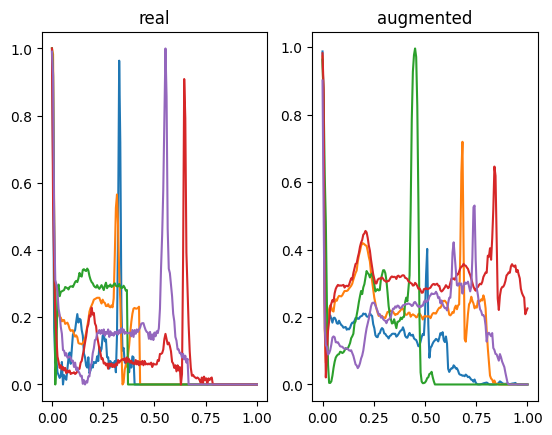

In [23]:
# Plot real and VAE-generated samples for class 0 (no anomalies)

plt.subplot(1, 2, 1)
for i in range(5):
    plt.plot(np.linspace(0, 1, seq_len), X0[i, :, 0])
    plt.title("real")
plt.subplot(1, 2, 2)
for i in range(5):
    plt.plot(np.linspace(0, 1, seq_len), X0_gen[i, :, 0])
    plt.title("augmented")
plt.show()

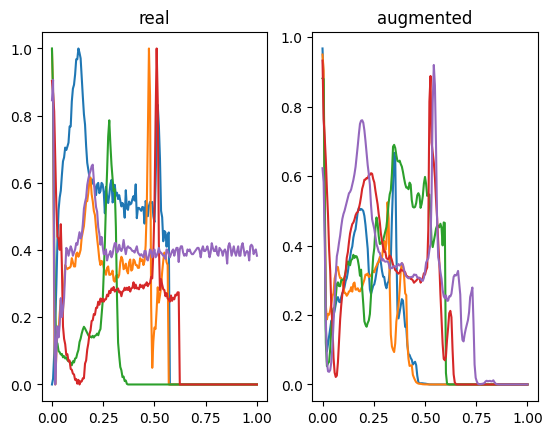

In [24]:
# Plot real and VAE-generated samples for class 1 (anomalies)

plt.subplot(1, 2, 1)
for i in range(5):
    plt.plot(np.linspace(0, 1, seq_len), X1[i, :, 0])
    plt.title("real")
plt.subplot(1, 2, 2)
for i in range(5):
    plt.plot(np.linspace(0, 1, seq_len), X1_gen[i, :, 0])
    plt.title("augmented")
plt.show()

The one-nearest neighbor classifier is often considered the baseline model in time series classification (Faouzi, 2024). Therefore, we use it as our downstream classifier. We use the simple Euclidean metric to measure distance between two time series. Although the DTW metric (Sakoe and Chiba, 1978) is considered better for time series classification (Faouzi, 2024) we stick to the simple Euclidean metric, because it proved to be almost as good for our downstream task.

In [12]:
# Implement one-nearest neighbor classifier

def one_nearest_neighbor(X_train, X_test, y_train, y_test):
    kNN = KNeighborsTimeSeriesClassifier(n_neighbors=1, metric="euclidean")
    y_train = np.argmax(y_train, axis=1).reshape((y_train.shape[0],))
    kNN.fit(X_train[:, :, 0], y_train)
    y_pred = kNN.predict(X_test[:, :, 0])
    y_test = np.argmax(y_test, axis=1).reshape((y_test.shape[0],))
    print(accuracy_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

First, we train the classifier using only the real train samples. We measure the classification accuracy using the test samples. Then, we use one of the chosen augmentation techniques to generate more train samples. We generate
10 000 augmented train samples, 5 000 for each class. The classifier is trained using the real and the augmented train samples, i.e., 12 000 samples. Again, we measure the classification accuracy using the test samples. This procedure is repeated for each of the chosen augmentation methods. See, e.g., the augmentations tutorial (https://github.com/AlexanderVNikitin/tsgm/blob/main/tutorials/augmentations.ipynb) for a description of the chosen methods. We experiment with a few different hyperparameter values and choose the values that give the best test accuracy.

In [20]:
# Evaluate test accuracy using only real data

print("no augmentations:")
X_train = np.concatenate((X0, X1))
y_train = np.concatenate((y0, y1))
one_nearest_neighbor(X_train, X_test, y_train, y_test)
print(" ")

# Evaluate test accuracy using classical augmentation methods

print("gaussian noise:")
aug = tsgm.models.augmentations.GaussianNoise()
X_aug, y_aug = aug.generate(X_train, y_train, n_samples=10*N, variance=0.2)
X_train_new = np.concatenate((X_train, X_aug))
y_train_new = np.concatenate((y_train, y_aug))
one_nearest_neighbor(X_train_new, X_test, y_train_new, y_test)
print(" ")

print("magnitude warping:")
aug = tsgm.models.augmentations.MagnitudeWarping()
y_train_ = np.argmax(y_train, 1)
X_aug, y_aug = aug.generate(X_train, y_train_, n_samples=10*N, sigma=0.5)
y_aug = tf.keras.utils.to_categorical(y_aug)
X_train_new = np.concatenate((X_train, X_aug))
y_train_new = np.concatenate((y_train, y_aug))
one_nearest_neighbor(X_train_new, X_test, y_train_new, y_test)
print(" ")

print("window warping:")
aug = tsgm.models.augmentations.WindowWarping()
y_train_ = np.argmax(y_train, 1)
X_aug, y_aug = aug.generate(X_train, y_train_, n_samples=10*N, scales=(0.75,1.25), window_ratio=0.25)
y_aug = tf.keras.utils.to_categorical(y_aug)
X_train_new = np.concatenate((X_train, X_aug))
y_train_new = np.concatenate((y_train, y_aug))
one_nearest_neighbor(X_train_new, X_test, y_train_new, y_test)
print(" ")

# Evaluate test accuracy using VAE

print("variational autoencoder:")
X_train_new = np.concatenate((X_train, X0_gen, X1_gen))
y_train_new = np.concatenate((y_train, y0, y0, y0, y0, y0, y1, y1, y1, y1, y1))
one_nearest_neighbor(X_train_new, X_test, y_train_new, y_test)

no augmentations:


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


0.896
[[902  98]
 [110 890]]
 
gaussian noise:


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


0.896
[[902  98]
 [110 890]]
 
magnitude warping:


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


0.9015
[[912  88]
 [109 891]]
 
window warping:


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


0.9205
[[935  65]
 [ 94 906]]
 
variational autoencoder:


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


0.906
[[916  84]
 [104 896]]


We observe that almost all of the chosen augmentation methods improve the test accuracy. In this case, window warping gives the best downstream performance.

References:

J. Faouzi. Time Series Classification: A Review of Algorithms and Implementations. Time Series Analysis - Recent Advances, New Perspectives and Applications, 2024.

A. Goldberger, L. Amaral, L. Glass, J. Hausdorff, P. Ivanov, R. Mark, ..., and H. Stanley. PhysioBank, PhysioToolkit, and PhysioNet: Components of a
New Research Resource for Complex Physiologic Signals.Circulation, 2000.

D. Kingma and M. Welling. An Introduction to Variational Autoencoders. Now Foundations and Trends, 2019.

G. Moody and R. Mark. The impact of the MIT-BIH Arrythmia Database. IEEE Engineering in Medicine and Biology Magazine, 2001.

H. Sakoe and S. Chiba. Dynamic Programming Algorithm Optimization for
Spoken Word Recognition. IEEE Transactions on Acoustics, Speech, and
Signal Processing, 1978.
